# Hazard class

A Hazard contains the following information:

- tag (TagHazard): information about the source
- units (str): units of the intensity
- centroids (Centroids): centroids of the events
- event_id (np.array): id (>0) of each event
- event_name (list(str)): name of each event (default: event_id)
- date (np.array): integer date corresponding to the proleptic Gregorian ordinal, where January 1 of year 1 has ordinal 1 (ordinal format of datetime library)
- frequency (np.array): frequency of each event in seconds
- orig_event (np.array): flags indicating historical events (True) or probabilistic (False)
- intensity (sparse.csr_matrix): intensity of the events at centroids
- fraction (sparse.csr_matrix): fraction of affected exposures for each event at each centroid

The `intensity` and `fraction` variables are sparse matrices of size num_events x num_centroids. The sparse matrix is an object defined in the scipy library. There are different types (row-wise, column-wise, linked-lists, ...) and functions that can be used with them: https://docs.scipy.org/doc/scipy/reference/sparse.html.

Like with the other climada classes, a `Hazard` can be filled from a file as follows:

In [1]:
%matplotlib inline
from climada.hazard import Hazard
from climada.util import HAZ_DEMO_MAT
# Unlike in other climada classes, Hazard needs to know the acronym of the hazard type in first place!!!
haz_tc_fl = Hazard('TC', HAZ_DEMO_MAT, 'Historic and synthetic tropical cyclones in Florida from 1851 to 2011.')
print()
print('Absolute file path of file read:', haz_tc_fl.tag.file_name)
print()
print('Hazard info:')
print(haz_tc_fl)

2019-01-23 08:41:45,085 - climada - DEBUG - Loading default config file: /Users/aznarsig/Documents/Python/climada_python/climada/conf/defaults.conf


/Users/aznarsig/anaconda3/envs/climada_env_new/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2019-01-23 08:41:45,976 - climada.hazard.base - INFO - Reading file: /Users/aznarsig/Documents/Python/climada_python/data/demo/atl_prob.mat
2019-01-23 08:41:46,055 - climada.hazard.centroids.base - INFO - Reading file: /Users/aznarsig/Documents/Python/climada_python/data/demo/atl_prob.mat
2019-01-23 08:41:46,100 - climada.util.checker - DEBUG - Centroids.region_id not set. 

Absolute file path of file read: /Users/aznarsig/Documents/Python/climada_python/data/demo/atl_prob.mat

Hazard info:


It has three different plot functions: `plot_intensity()`, `plot_fraction()`and `plot_rp_intensity()`. Depending on the inputs, different properties can be visualized. Check the documentation of a function:

In [2]:
help(haz_tc_fl.plot_intensity)
help(haz_tc_fl.plot_rp_intensity)

Help on method plot_intensity in module climada.hazard.base:

plot_intensity(event=None, centr=None, **kwargs) method of climada.hazard.base.Hazard instance
    Plot intensity values for a selected event or centroid.
    
    Parameters:
        event (int or str, optional): If event > 0, plot intensities of
            event with id = event. If event = 0, plot maximum intensity in
            each centroid. If event < 0, plot abs(event)-largest event. If
            event is string, plot events with that name.
        centr (int or tuple, optional): If centr > 0, plot intensity
            of all events at centroid with id = centr. If centr = 0,
            plot maximum intensity of each event. If centr < 0,
            plot abs(centr)-largest centroid where higher intensities
            are reached. If tuple with (lat, lon) plot intensity of nearest
            centroid.
        kwargs (optional): arguments for pcolormesh matplotlib function
            used in event plots
    
    

### EXERCICE

Plot:

1. intensities of the largest event
2. maximum intensities at each centroid
3. intensities of event HAZEL
4. tropical cyclone intensities maps for the return periods [10, 50, 75, 100]
5. intensities of all the events in centroid with id 50
6. intensities of all the events in centroid closest to lat, lon = (26.5, -81)

In [3]:
# Put your code here





2019-01-23 08:42:00,839 - climada.hazard.base - INFO - Computing exceedance intenstiy map for return periods: [ 10  50  75 100]


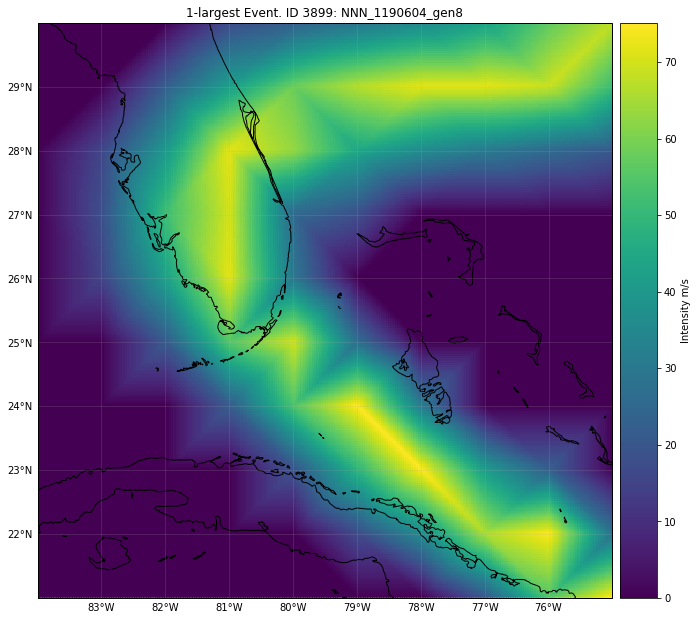

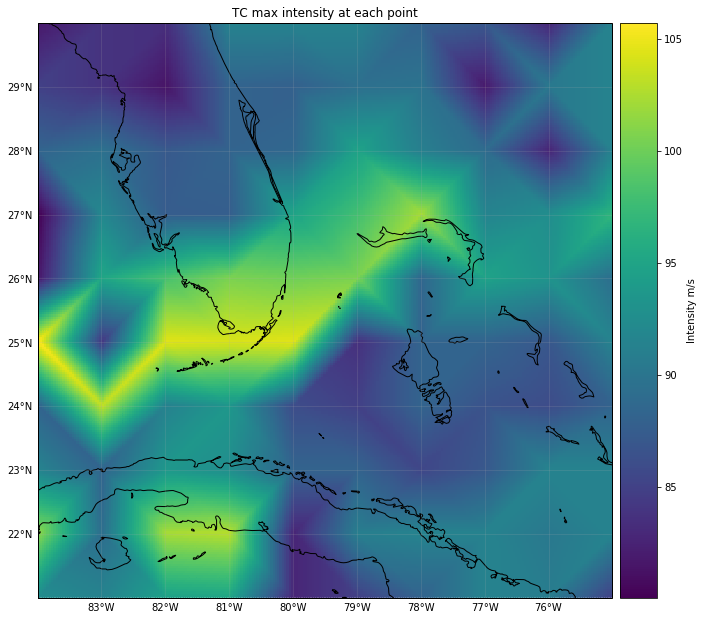

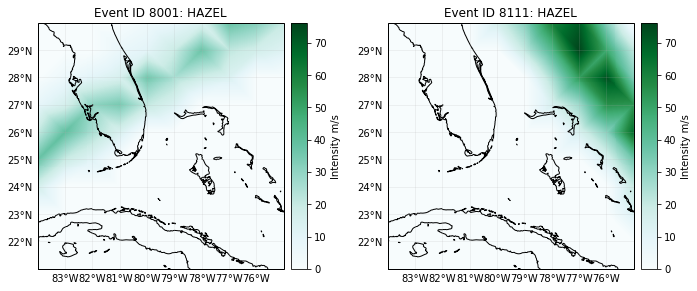

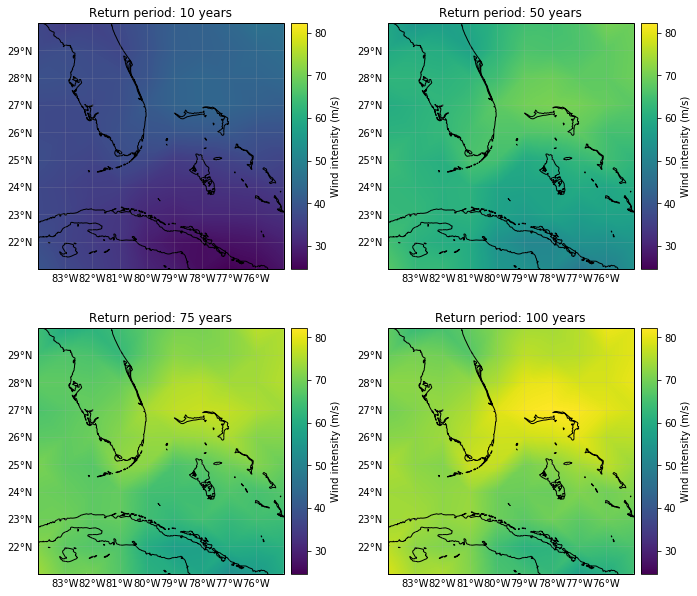

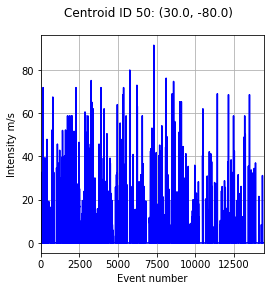

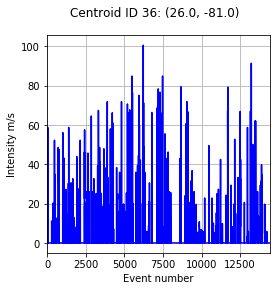

In [4]:
# SOLUTION:

# 1. intensities of the largest event:
haz_tc_fl.plot_intensity(event=-1)

# 2. maximum intensities at each centroid:
haz_tc_fl.plot_intensity(event=0)

# 3. intensities of event HAZEL:
haz_tc_fl.plot_intensity(event='HAZEL', cmap='BuGn') # setting color map

# 4. tropical cyclone intensities maps for the return periods [10, 50, 75, 100]
_, _, res = haz_tc_fl.plot_rp_intensity([10, 50, 75, 100])

# 5. intensities of all the events in centroid with id 50
haz_tc_fl.plot_intensity(centr=50)

# 5. intensities of all the events in centroid closest to lat, lon = (26.5, -81)
haz_tc_fl.plot_intensity(centr=(26.5, -81));

The following methods can be used to analyse the data in `Hazard`:

- `calc_year_set()` method returns a dictionary with all the historical (not synthetic) event ids that happened at each year. 
- `get_date_strings()` returns strings of dates in ISO format.
- To obtain the relation between event ids and event names, two methods can be used `event_id_to_name()` and `event_name_to_id()`. 

Finally, the methods `clear()` and `append()` are used to reinitialize the data in the `Hazard` instance and to expand the data with data from an other `Hazard`, respectively.

### EXERCISE:

1. How many hurricanes with the name `HAZEL` have happened in Florida? When did they take place?
2. How many tropical cyclones occured in year 2000?

In [5]:
# Put your code here:





In [6]:
# SOLUTION:

# 1. How many hurricanes with the name `HAZEL` have happened in Florida? When did they take place?
print('Number of events HAZEL:', haz_tc_fl.get_event_id('HAZEL').size)
print('Occurence of events HAZEL:', haz_tc_fl.get_event_date('HAZEL'))

# 2. Which is the year where more tropical cyclones have occured?
# First we compute the events per year
year_set = haz_tc_fl.calc_year_set()
print('Number of events in 2000:', year_set[2000].size)

Number of events HAZEL: 2
Occurence of events HAZEL: ['1953-10-07', '1954-10-05']
Number of events in 2000: 15
